In [1]:
%run init_notebook.py

In [2]:
import pickle
import spacy

import numpy as np
import guidedlda
import gensim.corpora as corpora
import gensim
import pyLDAvis.gensim
import pyLDAvis

from sklearn.feature_extraction.text import CountVectorizer

In [3]:
from src.utils import load_pickle

# load data

In [4]:
dict_txts = {}
for file in [i for i in os.listdir(TEXT_DIR) if i != 'orig']:
    dict_txts[file] = load_pickle(file)

lst_noun_tokens = [list(i['counter'].keys()) for i in dict_txts.values() if i['date'] >= datetime(2012,1,1)]

In [5]:
len(lst_noun_tokens)

101

# lda gensim

In [6]:
id2word = corpora.Dictionary(lst_noun_tokens)
corpus = [id2word.doc2bow(doc) for doc in lst_noun_tokens]

In [7]:
# number of topics
num_topics = 3
# Build LDA model
lda_gen = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, random_state=101)
# Print the Keyword in the 10 topics
print(lda_gen.print_topics())
doc_lda = lda_gen[corpus]

[(0, '0.006*"policy" + 0.006*"sector" + 0.006*"president" + 0.006*"condition" + 0.006*"assessment" + 0.006*"credit" + 0.006*"risk" + 0.006*"price" + 0.005*"economy" + 0.005*"demand"'), (1, '0.006*"quarter" + 0.006*"ecb" + 0.006*"household" + 0.006*"gdp" + 0.006*"credit" + 0.006*"policy" + 0.005*"outlook" + 0.005*"detail" + 0.005*"outcome" + 0.005*"price"'), (2, '0.006*"assessment" + 0.006*"growth" + 0.006*"interest" + 0.006*"press" + 0.006*"inflation" + 0.006*"financing" + 0.006*"term" + 0.005*"detail" + 0.005*"conference" + 0.005*"president"')]


In [8]:
# pyLDAvis.enable_notebook()
# LDAvis_prepared = pyLDAvis.gensim.prepare(lda_gen, corpus, id2word)
# LDAvis_prepared

In [9]:
c = [id2word.doc2bow(lst_noun_tokens[i]) for i in range(len(lst_noun_tokens))]
topics = {i: dict(lda_gen.get_document_topics(id2word.doc2bow(lst_noun_tokens[i]))) for i in range(len(lst_noun_tokens))}

In [10]:
df = pd.DataFrame(topics) #columns=dict_dates.values())
df.columns = [i['date'] for i in dict_txts.values() if i['date'] >= datetime(2012,1,1)]
df = df.T.sort_index()
df.columns = [f'topic_{i}' for i in df.columns]

In [12]:
lda_gen.print_topic(2)

'0.006*"assessment" + 0.006*"growth" + 0.006*"interest" + 0.006*"press" + 0.006*"inflation" + 0.006*"financing" + 0.006*"term" + 0.005*"detail" + 0.005*"conference" + 0.005*"president"'

<AxesSubplot:>

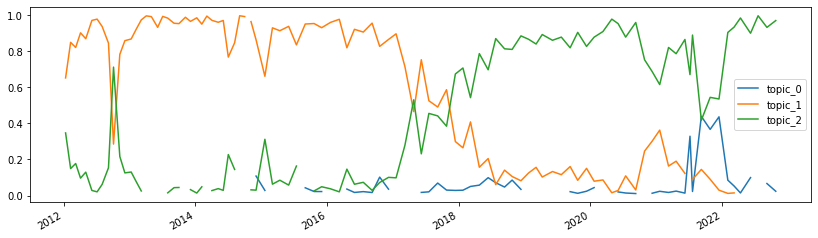

In [13]:
df.plot(figsize=(14,4))

# lda norm

In [14]:
voc = list(set([*chain(*lst_noun_tokens)]))

In [15]:
vectorizer = CountVectorizer(ngram_range=(1,1),vocabulary=voc)
vec = vectorizer.fit_transform([" ".join(i) for i in lst_noun_tokens])
X = vec.toarray()
word2id=vectorizer.vocabulary_

In [17]:
%%capture
lda = guidedlda.GuidedLDA(3, 2_000, random_state=101)
lda.fit(X)

INFO:guidedlda:n_documents: 101
INFO:guidedlda:vocab_size: 1187
INFO:guidedlda:n_words: 18399
INFO:guidedlda:n_topics: 3
INFO:guidedlda:n_iter: 2000
INFO:guidedlda:<0> log likelihood: -144693
INFO:guidedlda:<20> log likelihood: -124636
INFO:guidedlda:<40> log likelihood: -121270
INFO:guidedlda:<60> log likelihood: -120539
INFO:guidedlda:<80> log likelihood: -119821
INFO:guidedlda:<100> log likelihood: -119795
INFO:guidedlda:<120> log likelihood: -119488
INFO:guidedlda:<140> log likelihood: -119475
INFO:guidedlda:<160> log likelihood: -119512
INFO:guidedlda:<180> log likelihood: -119622
INFO:guidedlda:<200> log likelihood: -119475
INFO:guidedlda:<220> log likelihood: -119418
INFO:guidedlda:<240> log likelihood: -119378
INFO:guidedlda:<260> log likelihood: -119374
INFO:guidedlda:<280> log likelihood: -119419
INFO:guidedlda:<300> log likelihood: -119314
INFO:guidedlda:<320> log likelihood: -119303
INFO:guidedlda:<340> log likelihood: -119498
INFO:guidedlda:<360> log likelihood: -119514
IN

In [18]:
topic_word = lda.topic_word_
n_top_words = 8
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(voc)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: pandemic question consumer funding spending cent emergency frankfurt
Topic 1: sector detail assessment interest policy conference term price
Topic 2: sale question securitisation consolidation cycle action expectation provision


In [19]:
df = pd.DataFrame(lda.doc_topic_, index=[i['date'] for i in dict_txts.values() if i['date'] >= datetime(2012,1,1)]).sort_index()

<AxesSubplot:>

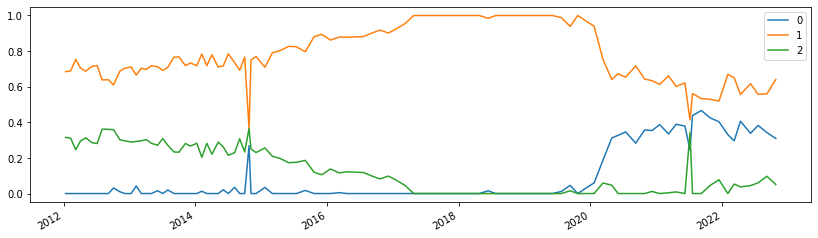

In [20]:
df.plot(figsize=(14,4))

# guided lda

In [21]:
lst_topic_seeds = [[i[0] for i in lda_gen.show_topic(topic)] for topic in range(lda_gen.num_topics)]

In [34]:
lst_topic_seeds = [
  ['term', 'condition', 'conference',  'corporation'],
  ['risk',  'outlook',  'assessment',  'credit',  'outcome',  'loan'],
  ['interest',  'economy',  'policy',  'prices',  'household',  'sector',  'inflation',  'expectation']
]

In [35]:
glda = guidedlda.GuidedLDA(n_topics=3, n_iter=4_000, random_state=7, refresh=20)

In [36]:
%%capture
seed_topics = {}
for t_id, st in enumerate(lst_topic_seeds):
    for word in st:
        seed_topics[word2id[word]] = t_id

glda.fit(X, seed_topics=seed_topics, seed_confidence=0.15)

INFO:guidedlda:n_documents: 101
INFO:guidedlda:vocab_size: 1187
INFO:guidedlda:n_words: 18399
INFO:guidedlda:n_topics: 3
INFO:guidedlda:n_iter: 4000
INFO:guidedlda:<0> log likelihood: -144641
INFO:guidedlda:<20> log likelihood: -125866
INFO:guidedlda:<40> log likelihood: -123088
INFO:guidedlda:<60> log likelihood: -122152
INFO:guidedlda:<80> log likelihood: -121474
INFO:guidedlda:<100> log likelihood: -121150
INFO:guidedlda:<120> log likelihood: -120718
INFO:guidedlda:<140> log likelihood: -120436
INFO:guidedlda:<160> log likelihood: -120348
INFO:guidedlda:<180> log likelihood: -120324
INFO:guidedlda:<200> log likelihood: -120092
INFO:guidedlda:<220> log likelihood: -119972
INFO:guidedlda:<240> log likelihood: -120135
INFO:guidedlda:<260> log likelihood: -119967
INFO:guidedlda:<280> log likelihood: -119583
INFO:guidedlda:<300> log likelihood: -119662
INFO:guidedlda:<320> log likelihood: -119677
INFO:guidedlda:<340> log likelihood: -119385
INFO:guidedlda:<360> log likelihood: -119154
IN

In [37]:
n_top_words = 10
topic_word = glda.topic_word_
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(voc)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: pandemic commitment spending expectation funding emergency cent frankfurt symmetry consumer
Topic 1: detail press interest policy conference condition term risk sector price
Topic 2: consolidation expectation sale picture securitisation funding competitiveness flash product action


In [38]:
df = pd.DataFrame(glda.doc_topic_, index=[i['date'] for i in dict_txts.values() if i['date'] >= datetime(2012,1,1)]).sort_index()

<AxesSubplot:>

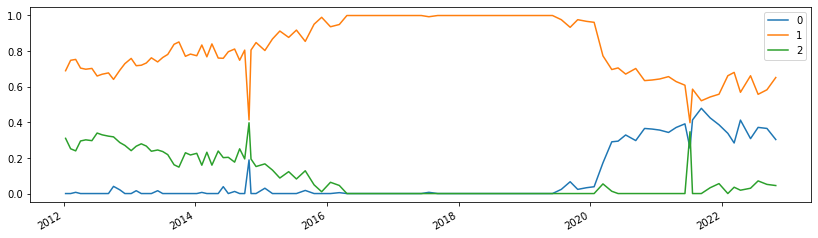

In [40]:
df.plot(figsize=(14,4))